In [1]:
# # Install tempo-embeddings from GitHub
# # This can also refer to a specific version or branch

# %pip install --upgrade pip  # Required for properly resolving dependencies
# %pip uninstall -y tempo_embeddings  # Remove existing installation
# %pip install --upgrade git+https://github.com/Semantics-of-Sustainability/tempo-embeddings.git

In [2]:
# make sure installation has succeeded
import tempo_embeddings

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [3]:
%load_ext autoreload

In [4]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Collection from Database

In [5]:
%autoreload now

from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

In [6]:
from tempo_embeddings.embeddings.vector_database import ChromaDatabaseManager

# Here we load only the ANP collection because metadata field names diverge across datasets
db = ChromaDatabaseManager(db_path="testing_db", batch_size=24)
db.connect()

print(f"Available collections in DB: {db.get_available_collections()}")

anp_sg_collection = db.get_existing_collection("anp_sg_corpus")
print(anp_sg_collection.count())

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
11:07:21 INFO:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
11:07:21 INFO:Path 'testing_db' already exists. Loading DB configuration:
{'embedder_name': 'NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers', 'embedder_type': 'custom_model', 'existing_collections': ['anp_sg_corpus', 'anp_duurzam']}
11:07:21 INFO:Retrieved existing collection 'anp_sg_corpus'


Available collections in DB: ['anp_sg_corpus', 'anp_duurzam']
1558


## Create Sub-Collections

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [8]:
widget_year_range=widgets.IntRangeSlider(description='Year Range: ', min=1900, max=2020, step=1, value=(1980,1984))
widget_terms=widgets.Text(description='Filter Terms (comma separated)', value="duurzaam")
widget_neighbors=widgets.IntSlider(description="Expand Neighborhood Size: ", min=0, max=10, value=5)

In [9]:
display(widget_terms)
display(widget_year_range)
display(widget_neighbors)

Text(value='duurzaam', description='Filter Terms (comma separated)')

IntRangeSlider(value=(1980, 1984), description='Year Range: ', max=2020, min=1900)

IntSlider(value=5, description='Expand Neighborhood Size: ', max=10)

In [10]:
# Unpack values form Widget
year_from, year_to = widget_year_range.value
years = [str(x) for x in range(year_from, year_to+1)]
FILTER_TERMS = []#[s.strip() for s in widget_terms.value.split(",")]
# Execute Database Query
where_range = {"year": {"$in": years}}
print(f"Searching terms {FILTER_TERMS} between year {year_from} and {year_to}")
corpus = db.get_corpus(anp_sg_collection, filter_words=FILTER_TERMS, where_obj=where_range, include_embeddings=True, limit=10000)
print(f"Found {len(corpus)} items that match!")

Searching terms [] between year 1980 and 1984
Found 54 items that match!


## Choose Year and Plot Passages

In [11]:
import statistics
def get_corpus_with_neighborhoods(collection, corpus, k_neighbors):
    all_neighbors = []
    all_distances = []
    for p in corpus.passages:
        neighbors = db.query_vector_neighbors(collection, vector=p.embedding, k_neighbors=k_neighbors)
        for passage, distance in neighbors:
            all_neighbors.append(passage)
            all_distances.append(distance)
    print(f"Total Datapoints in the neighborhoods = {len(all_neighbors)}")
    print(f"Distance Info: Max = {max(all_distances)} | Min = {min(all_distances)} | Average = {statistics.mean(all_distances)}")
    # Join original passages + new found neighbors
    all_passages = corpus.passages + all_neighbors
    corpus = Corpus(all_passages)
    corpus.embeddings = db.compress_embeddings(corpus)
    print(corpus.embeddings.shape)
    return corpus

corpus = get_corpus_with_neighborhoods(anp_sg_collection, corpus, k_neighbors=widget_neighbors.value)

Total Datapoints in the neighborhoods = 270
Distance Info: Max = 0.6446640491485596 | Min = -1.3113021850585938e-06 | Average = 0.2709869815243615
UMAP( verbose=True)
Thu May 16 11:07:21 2024 Construct fuzzy simplicial set
Thu May 16 11:07:21 2024 Finding Nearest Neighbors
Thu May 16 11:07:22 2024 Finished Nearest Neighbor Search
Thu May 16 11:07:23 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu May 16 11:07:25 2024 Finished embedding
(324, 2)


## Cluster

In [12]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"
c_size = 8
clusters = corpus.cluster(min_cluster_size=c_size, cluster_selection_epsilon=0.1)
print(f"Found {len(clusters)} clusters in the corpus. (min cluster size is {c_size})")
for c in clusters:
    print(len(c.passages), c)

Found 17 clusters in the corpus. (min cluster size is 8)
41 Subcorpus(2, [0, 11, 12, 28, 41, 45, 54, 55, 56, 57])
19 Subcorpus(7, [1, 31, 35, 49, 59, 60, 61, 63, 183, 209])
20 Subcorpus(8, [2, 7, 26, 64, 65, 89, 90, 103, 158, 178])
20 Subcorpus(9, [3, 6, 19, 39, 69, 70, 71, 72, 84, 85])
13 Subcorpus(3, [4, 16, 32, 74, 75, 76, 78, 134, 135, 136])
36 Subcorpus(4, [5, 20, 37, 50, 53, 66, 79, 81, 91, 93])
16 Subcorpus(10, [8, 9, 29, 77, 94, 95, 99, 137, 138, 188])
10 Subcorpus(14, [10, 23, 104, 105, 169, 170, 182, 213, 243, 268])
50 Subcorpus(1, [13, 15, 17, 18, 24, 33, 38, 106, 108, 119])
18 Subcorpus(6, [14, 22, 46, 124, 125, 126, 127, 128, 164, 165])
8 Subcorpus(15, [21, 40, 159, 160, 163, 254, 255, 256])
11 Subcorpus(11, [25, 42, 62, 179, 180, 211, 232, 233, 264, 265])
15 Subcorpus(0, [27, 30, 100, 101, 189, 190, 204, 205, 226, 238])
18 Subcorpus(5, [34, 47, 67, 68, 83, 92, 97, 156, 177, 191])
10 Subcorpus(12, [36, 48, 234, 235, 247, 248, 294, 295, 297, 303])
8 Subcorpus(13, [43, 52, 8

## Cluster

In [13]:
import os
if not os.path.exists("clusters"): 
    os.makedirs("clusters")

selected_metadata = ["year"]

all_clusters_records, df_cluster_labels, df_cluster_meta = [], [], []
for cluster in clusters:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    df = cluster.to_dataframe()
    # df = df.drop_duplicates(subset=["ID_DB"])
    # if "year" in df.columns(): df_cluster_years.append(df["year"])
    centroid = cluster.centroid()
    label = cluster.label
    cluster_size = len(cluster.passages)
    # Compute Cluster Stats as a Subcorpus
    top_words = " ".join(cluster.top_words(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=10))
    all_clusters_records.append((f"{label}\t{cluster_size}\t{centroid}\t{top_words}\n"))
    df_cluster_labels.append(cluster.label)
    df_cluster_meta.append(df[selected_metadata])
    print(df[selected_metadata])
    # Save the Cluster Passages in a File
    file_prefix = f"cluster_{year_from}_{year_to}_{cluster.label.replace('; ', '_')}"
    df.to_csv(f"clusters/{file_prefix}.tsv", sep="\t", index=False) 
    print(cluster)

    year
0   1983
1   1983
2   1983
3   1983
4   1983
5   1983
6   1983
7   1983
8   1983
9   1983
10  1983
11  1983
12  1983
13  1983
14  1983
15  1983
16  1983
17  1983
18  1983
19  1983
20  1983
21  1983
22  1983
23  1983
24  1983
25  1983
26  1983
27  1983
28  1983
29  1983
30  1983
31  1983
32  1983
33  1983
34  1983
35  2017
36  1983
37  1983
38  1983
39  1983
40  1983
Subcorpus('betere; nabije; ondanks; toekomst; verwachting', [0, 11, 12, 28, 41, 45, 54, 55, 56, 57])
    year
0   1984
1   1984
2   1984
3   1984
4   1984
5   1984
6   1984
7   2018
8   1984
9   1984
10  1984
11  1984
12  1984
13  1984
14  1984
15  1984
16  1984
17  1984
18  1984
Subcorpus('beiroet; maatregelen; regering; vaag; vorming', [1, 31, 35, 49, 59, 60, 61, 63, 183, 209])
    year
0   1983
1   1983
2   1983
3   1983
4   1983
5   1983
6   1983
7   1983
8   1983
9   1983
10  1983
11  1983
12  1983
13  1983
14  1983
15  1983
16  1983
17  1983
18  1983
19  1983
Subcorpus('afzonderlijke; economen; economiën; ter

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
with open(f"clusters/clusters_all_{year_from}_{year_to}.csv", "wt") as f:
    f.write("Label\tSize\tCentroid\tTopWords\n")
    for rec in all_clusters_records:
        f.write(rec)

11:13:46 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:13:46 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:13:46 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:13:46 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:13:46 INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data ty

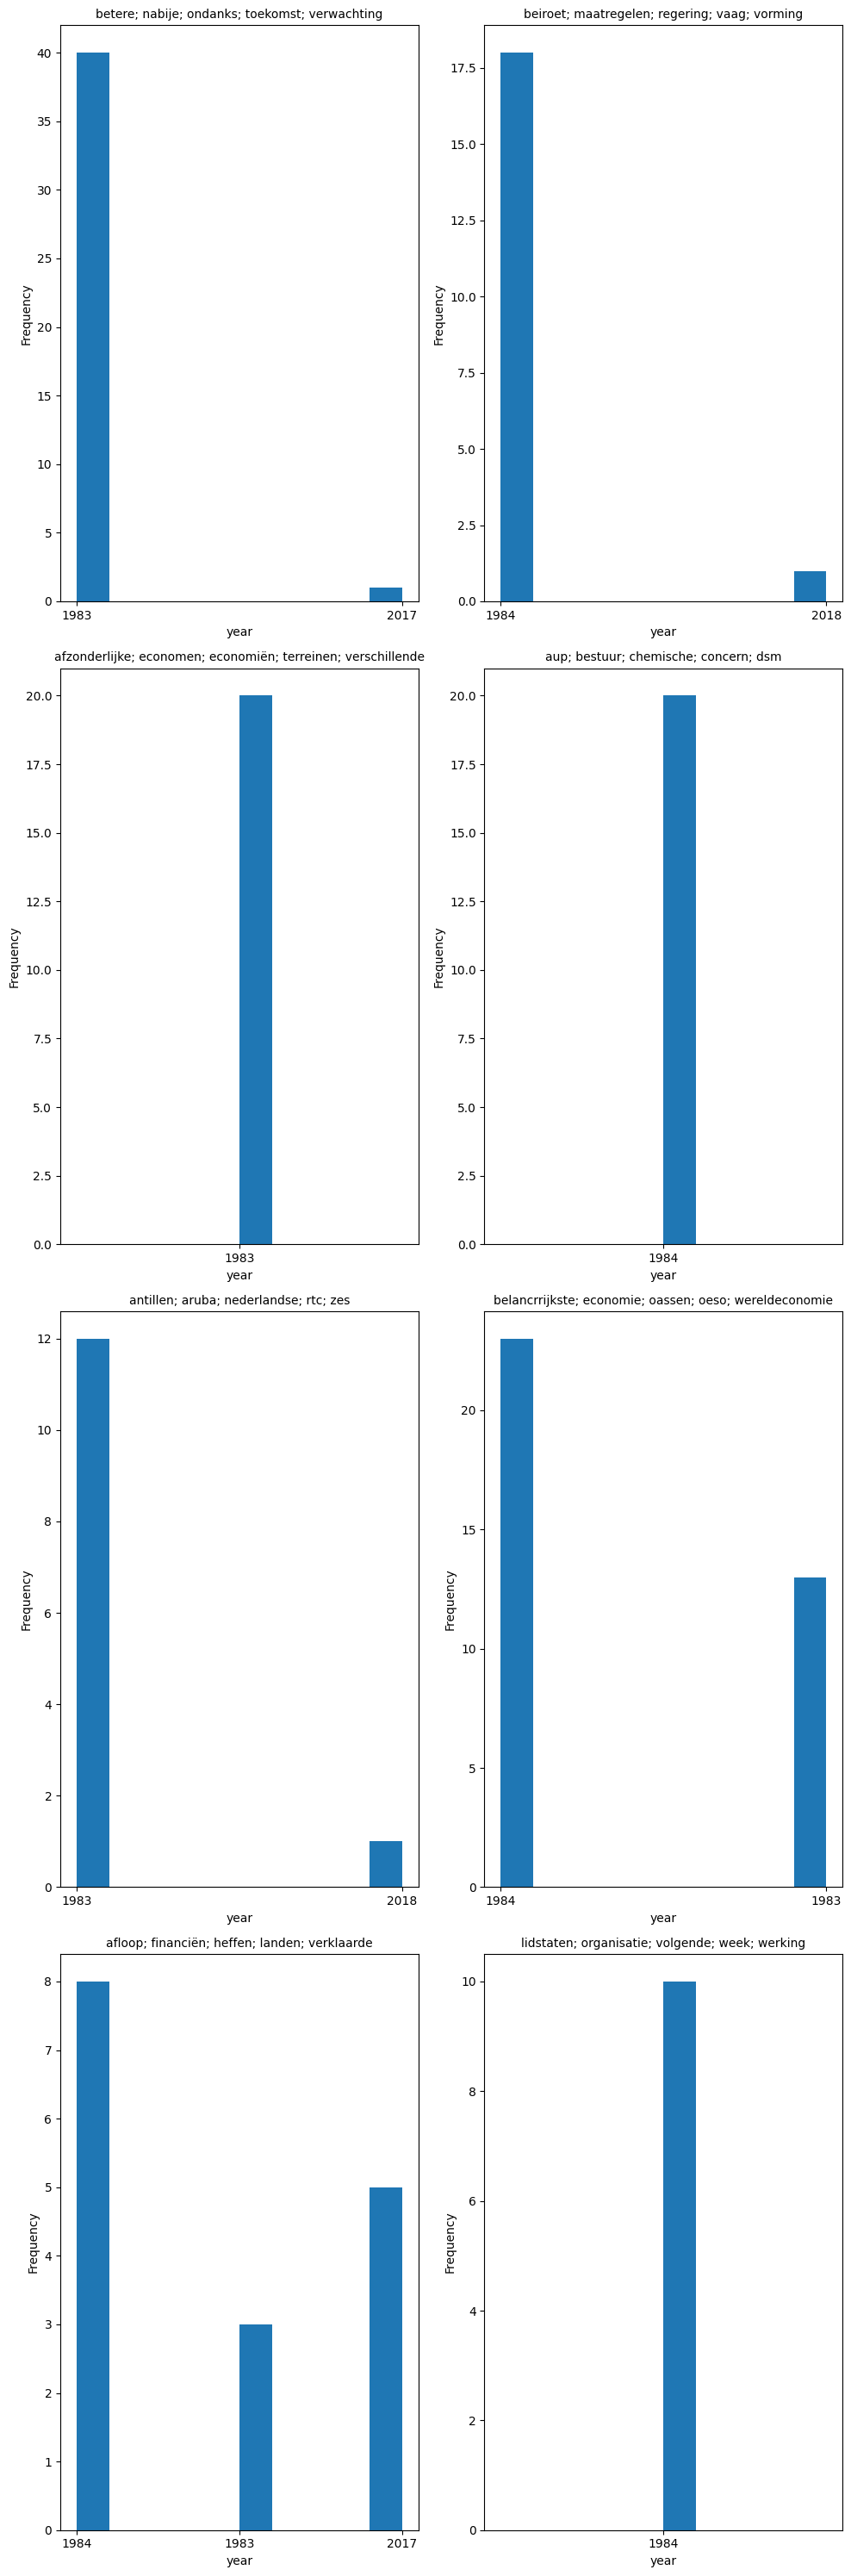

In [25]:
import matplotlib.pyplot as plt

# Variable name to plot
variable_name = 'year'

num_rows = len(df_cluster_meta)//2
if num_rows%2 != 0: 
    num_rows += 1
# If there are too many cluster we will just plot the first 10
if num_rows > 10:
    num_rows = 10

# Create subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(10, 30))

# Iterate through each DataFrame and plot histogram
axs = axs.flatten()
for i, df in enumerate(df_cluster_meta):
    ax = axs[i]
    ax.hist(df[variable_name])
    ax.set_title(f'{df_cluster_labels[i]}', fontsize=10)
    ax.set_xlabel(variable_name)
    ax.set_ylabel('Frequency')
    if i+1 == num_rows*2:
        break

# Adjust layout
plt.tight_layout()
plt.show()

# Visualize Embeddings

In [26]:
import os
from bokeh.io import output_notebook
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer

output_notebook()

meta_fields = corpus.metadata_fields()
meta_fields = ["year", "date", "issue"]

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=meta_fields, width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"

show(visualizer.create_document)

Loading BokehJS ...

11:14:55 INFO:Starting Bokeh server version 3.3.3 (running on Tornado 6.4)
11:14:55 INFO:User authentication hooks NOT provided (default user enabled)


11:14:55 INFO:WebSocket connection opened
11:14:55 INFO:ServerConnection created
